In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

In [10]:
try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU not active!


A search has been initiated within the folder named 'Dataset'.
There are 3220 images in the Non_Demented folder.
There are 940 images in the Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 2280 images in the Very_Mild_Demented folder.
The search has been completed.


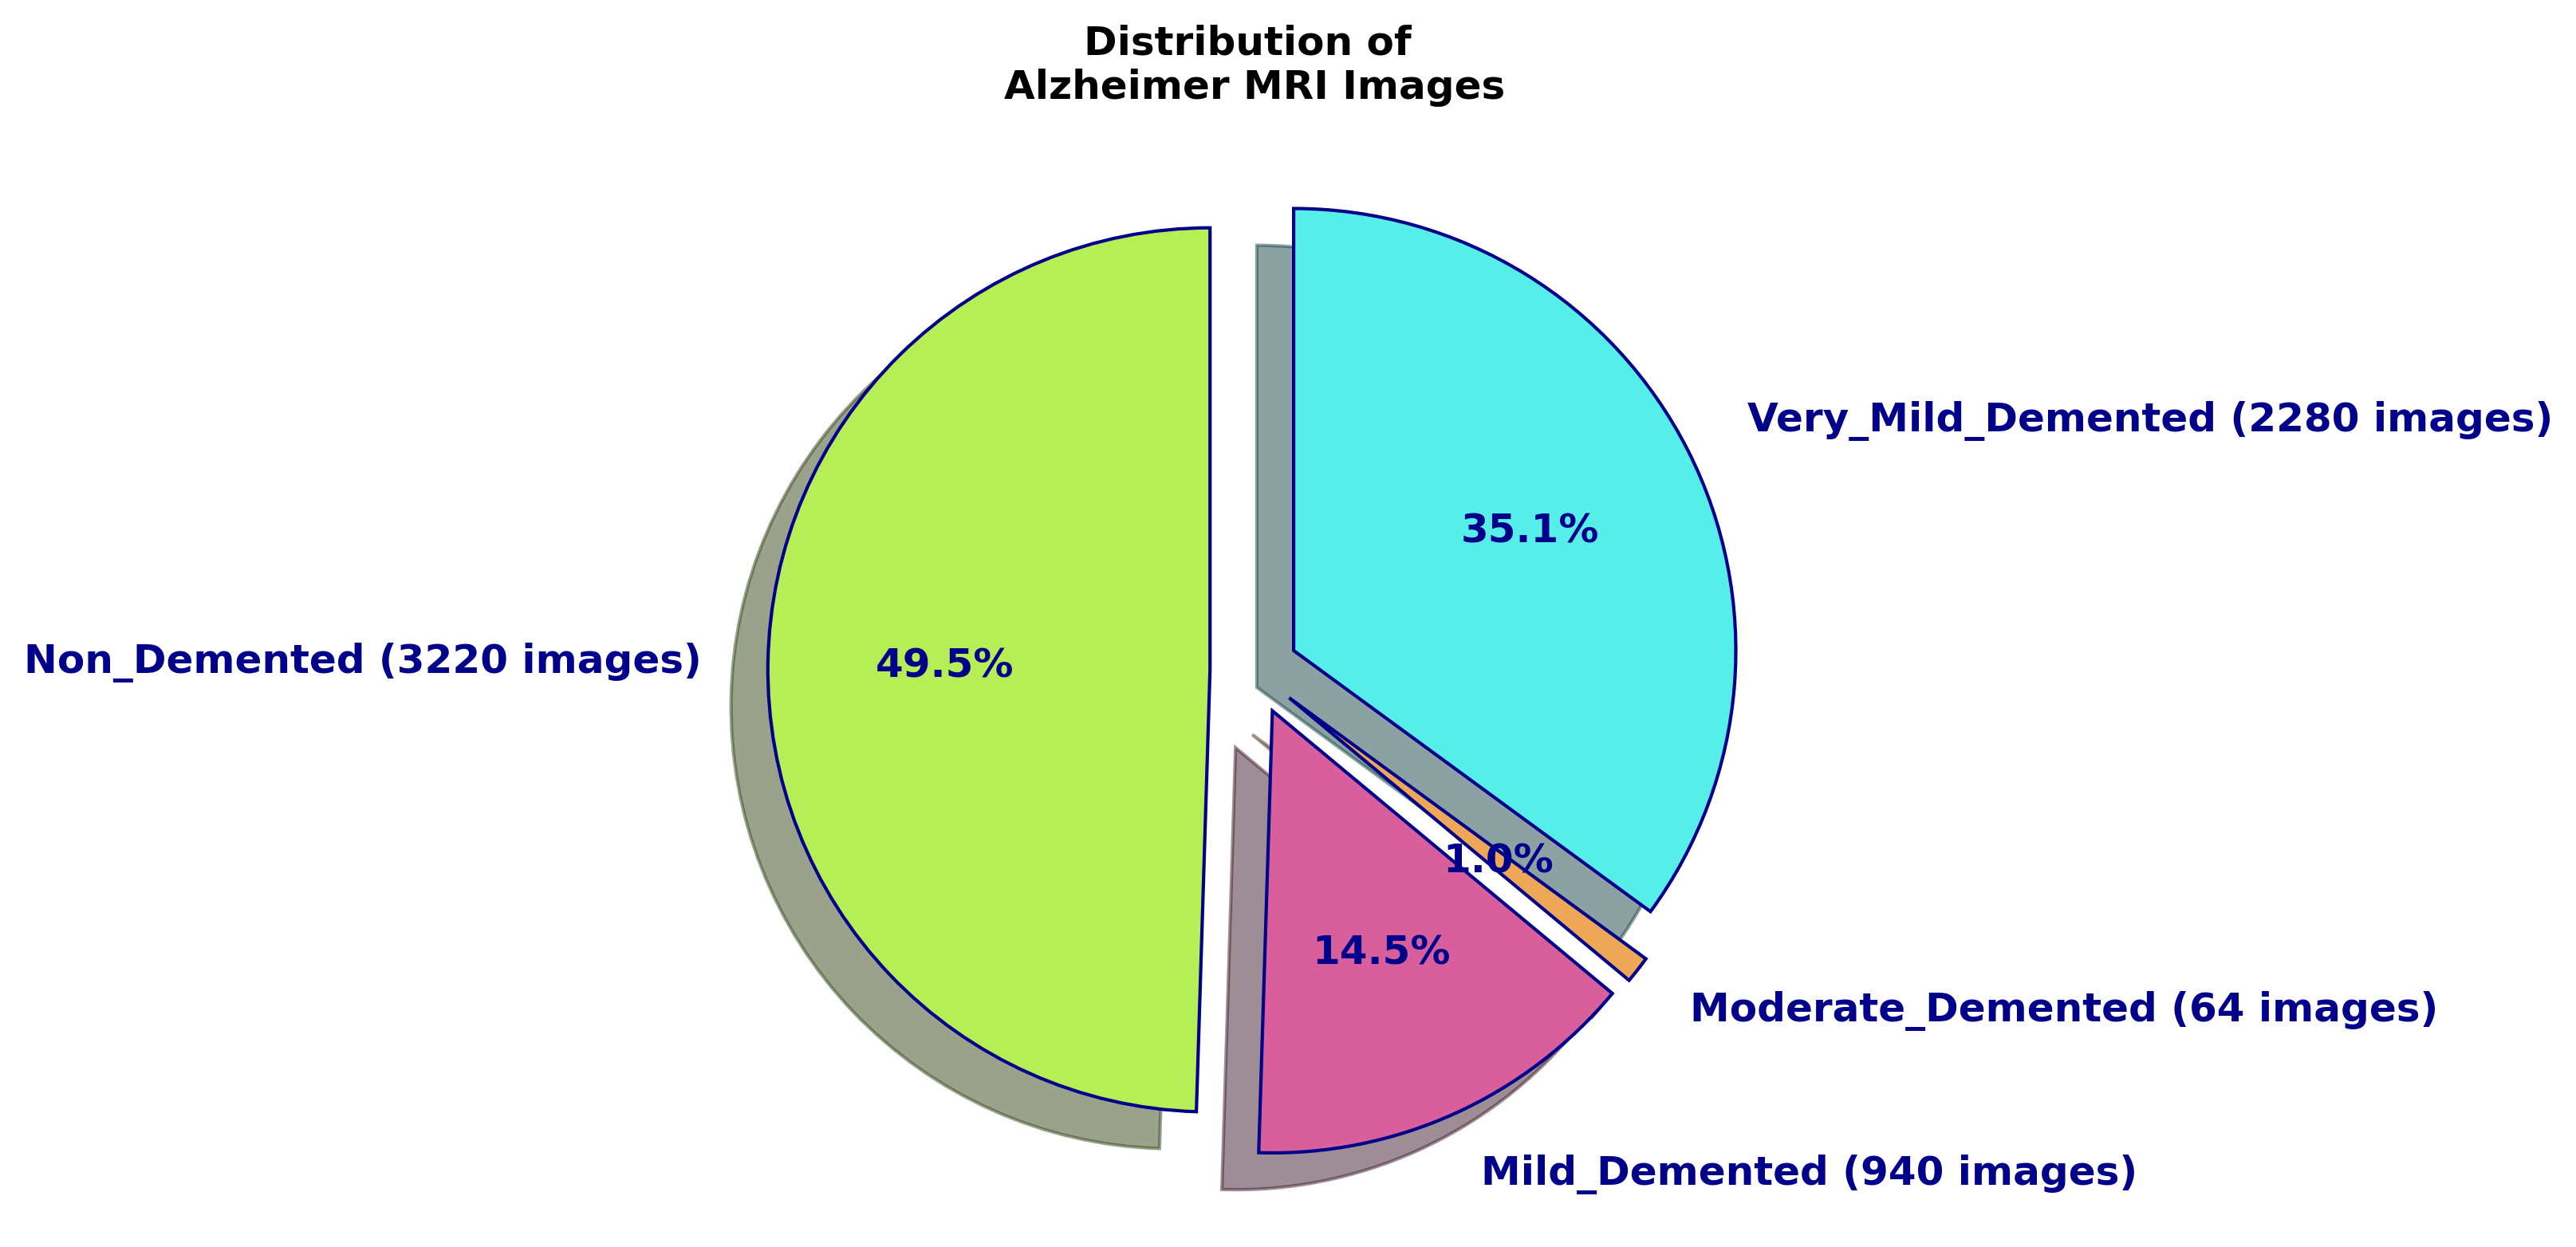

In [11]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1

            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)

    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold")

PATH = '/content/drive/MyDrive/Dataset'

image_counter(PATH)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 6504 files belonging to 4 classes.


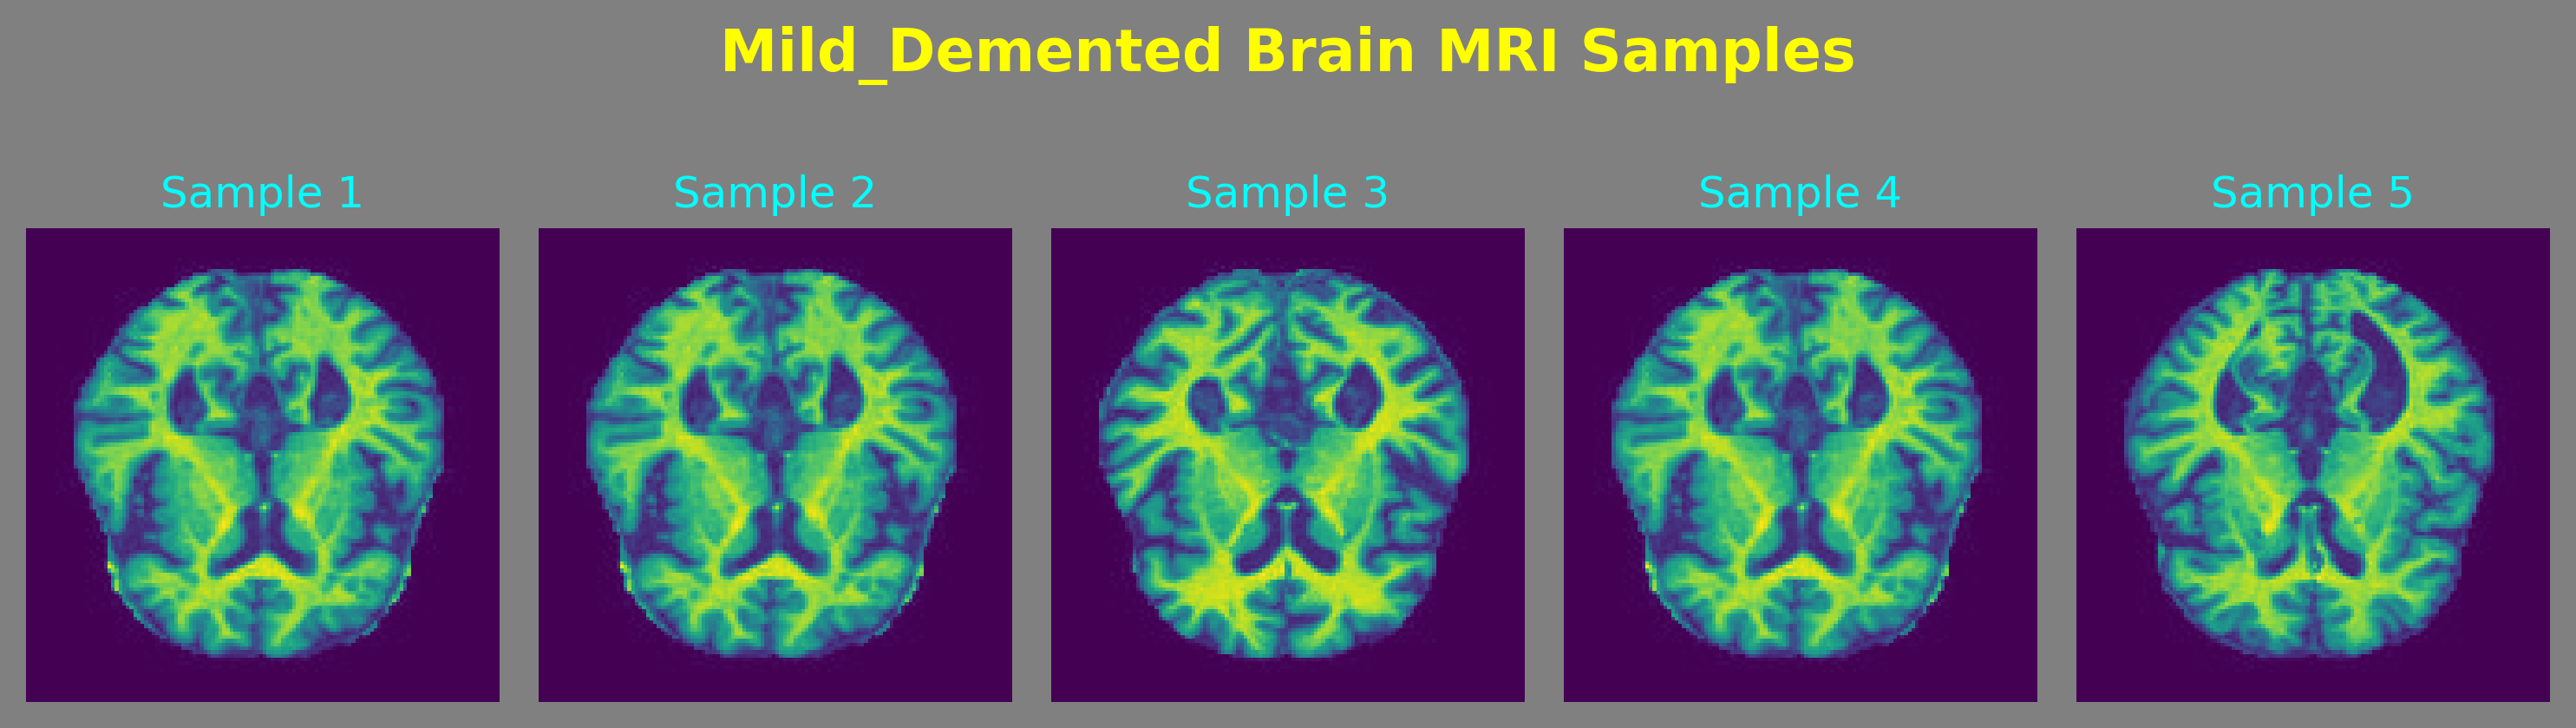

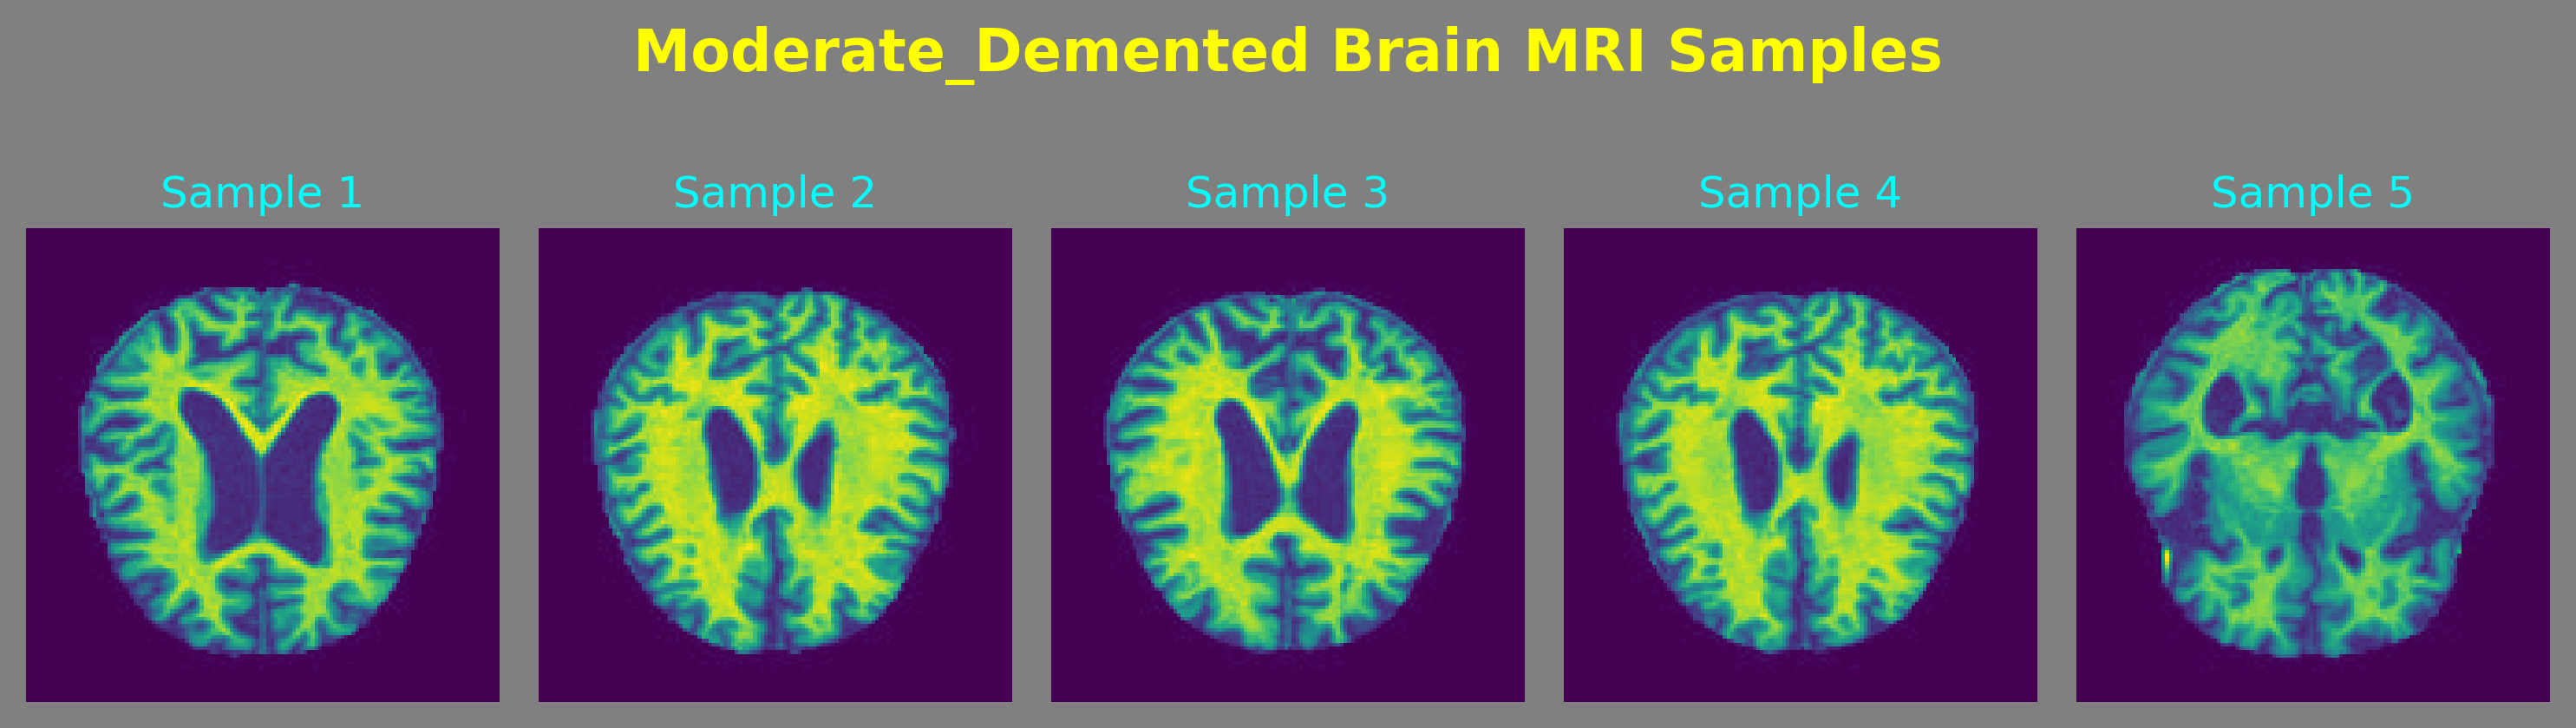

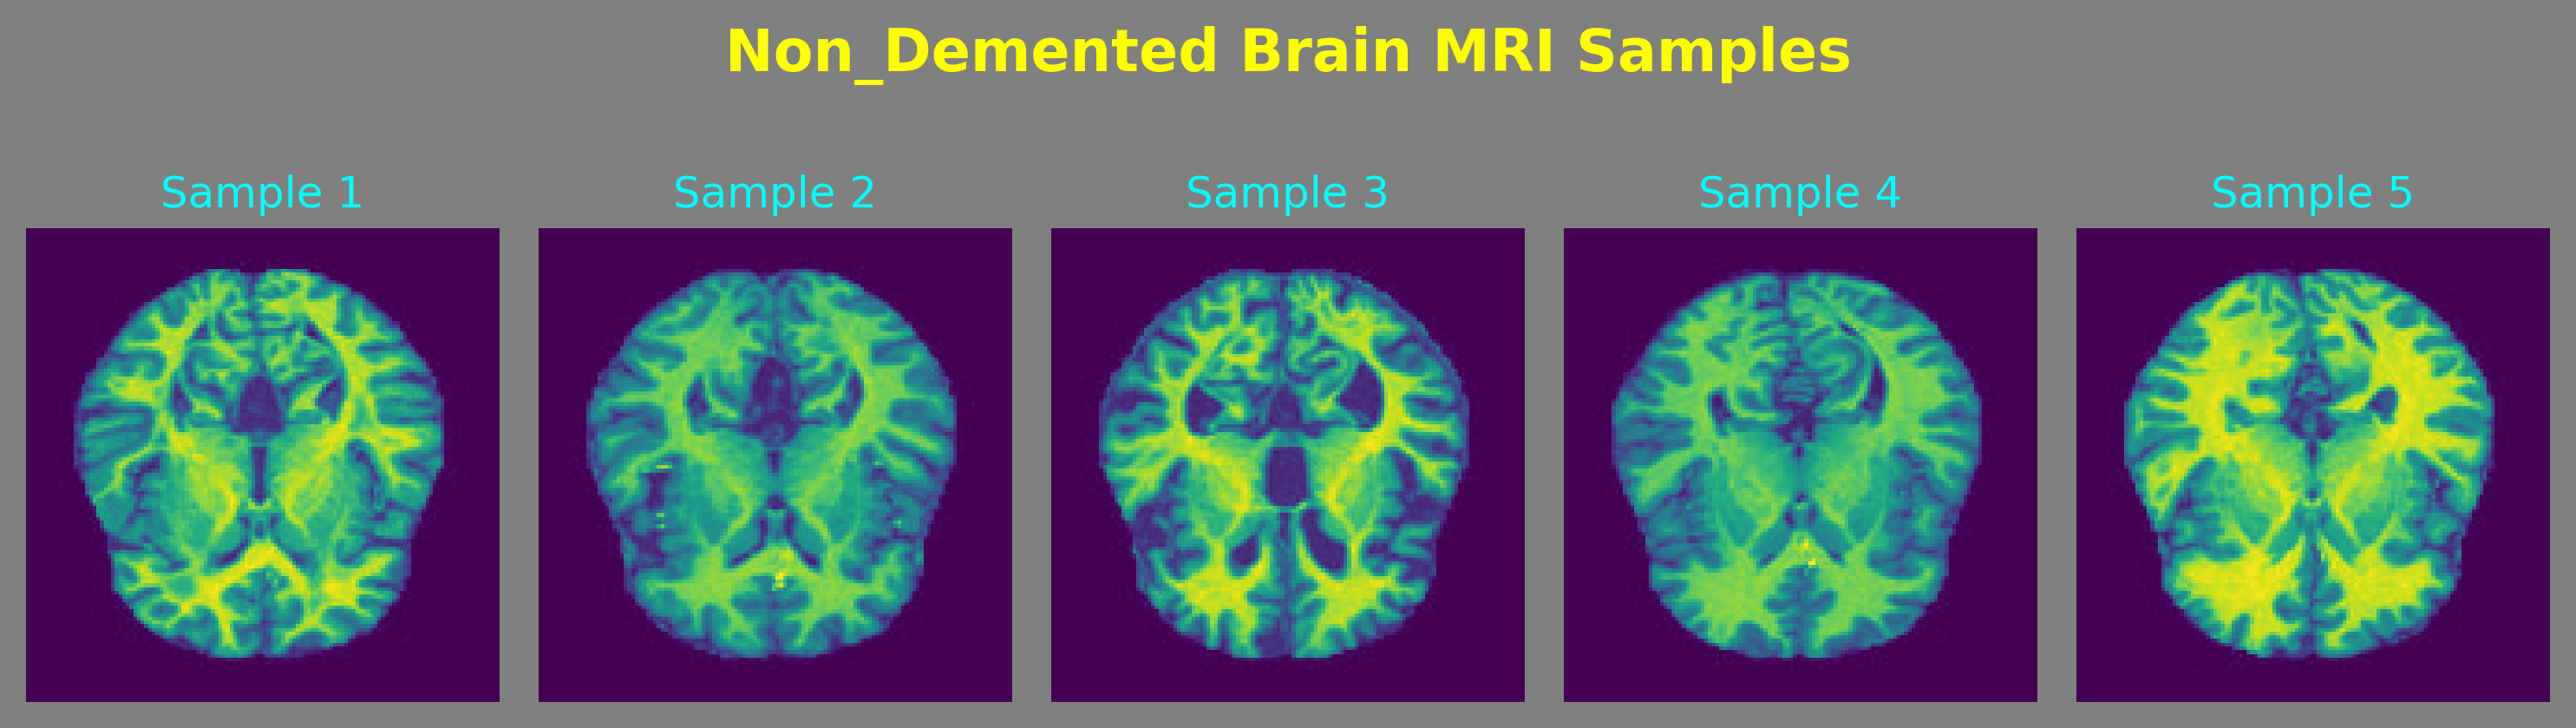

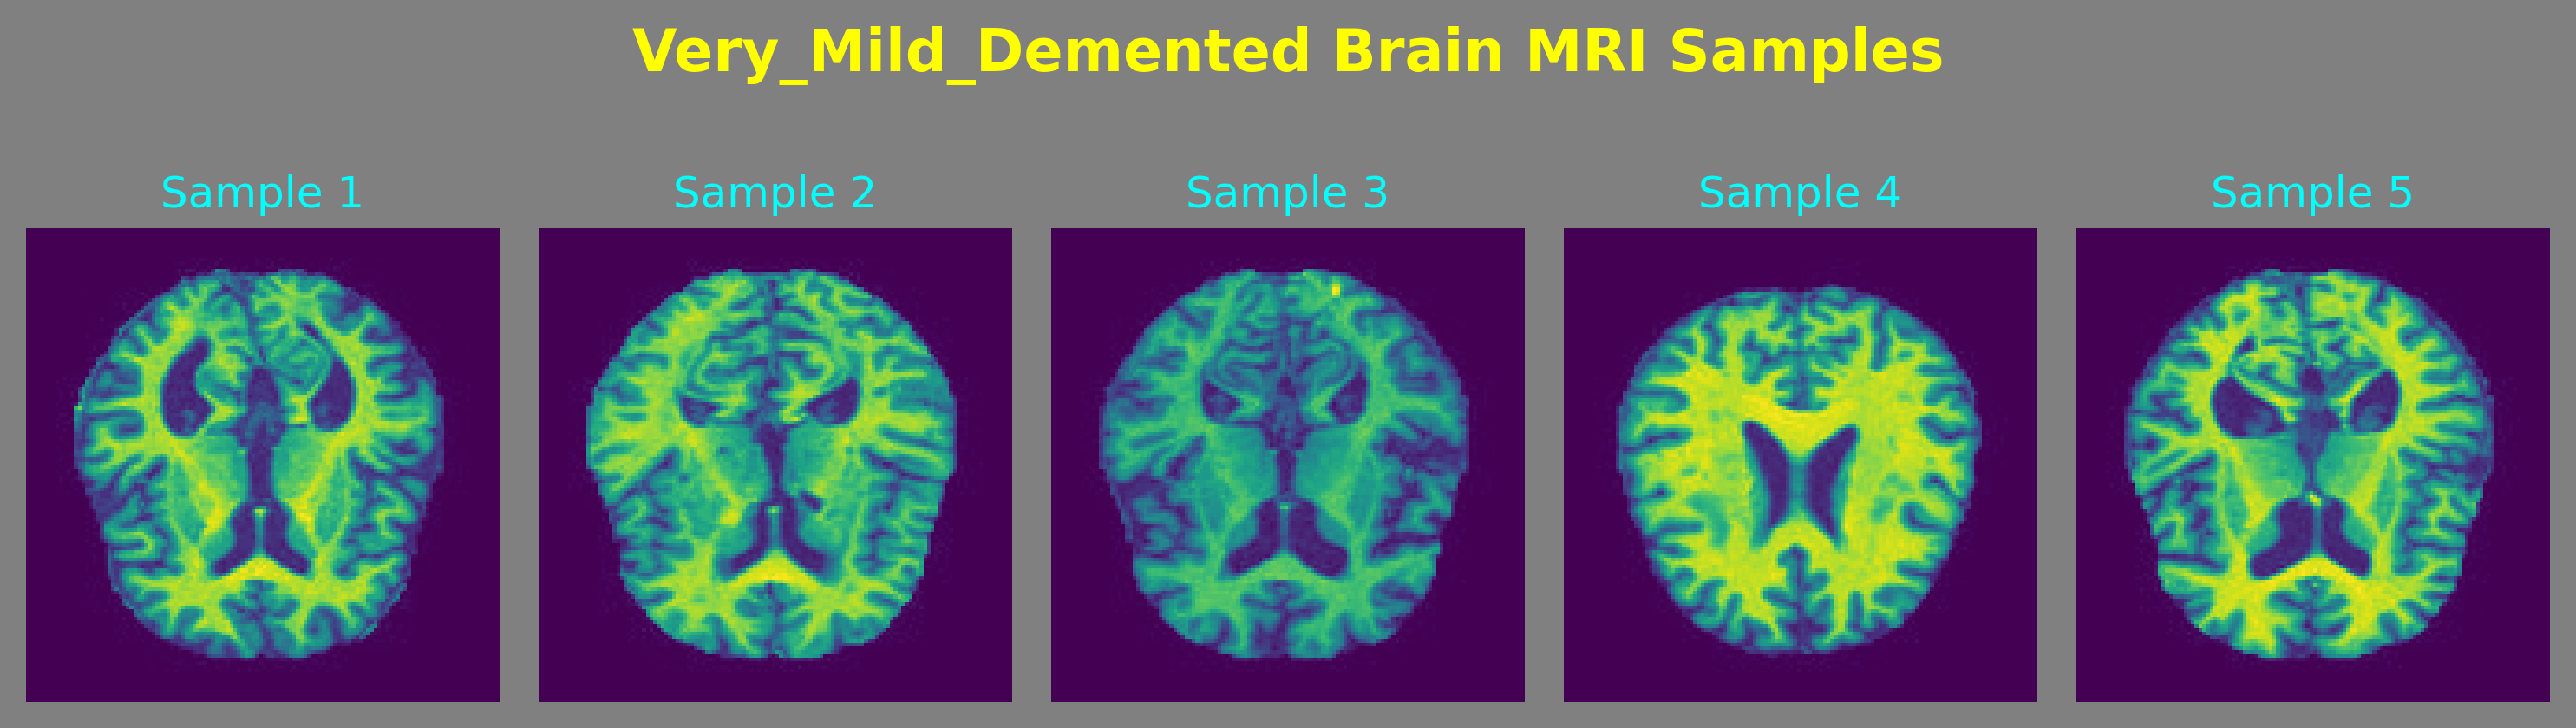

In [14]:
def sample_bringer(path, target, num_samples=5):

    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray")
    fig.suptitle(f'{target} Brain MRI Samples', color="yellow",fontsize=16, fontweight='bold', y=0.75)

    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()

for target in class_names:
    sample_bringer(PATH, target=target)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">Pixel normalization improves the performance of a neural network. Therefore, we will go with pixel values from 0 to 1, rather than values in the range 0 to 255.</p>

In [15]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Min and max pixel values in the batch -> 0.0 & 1.0


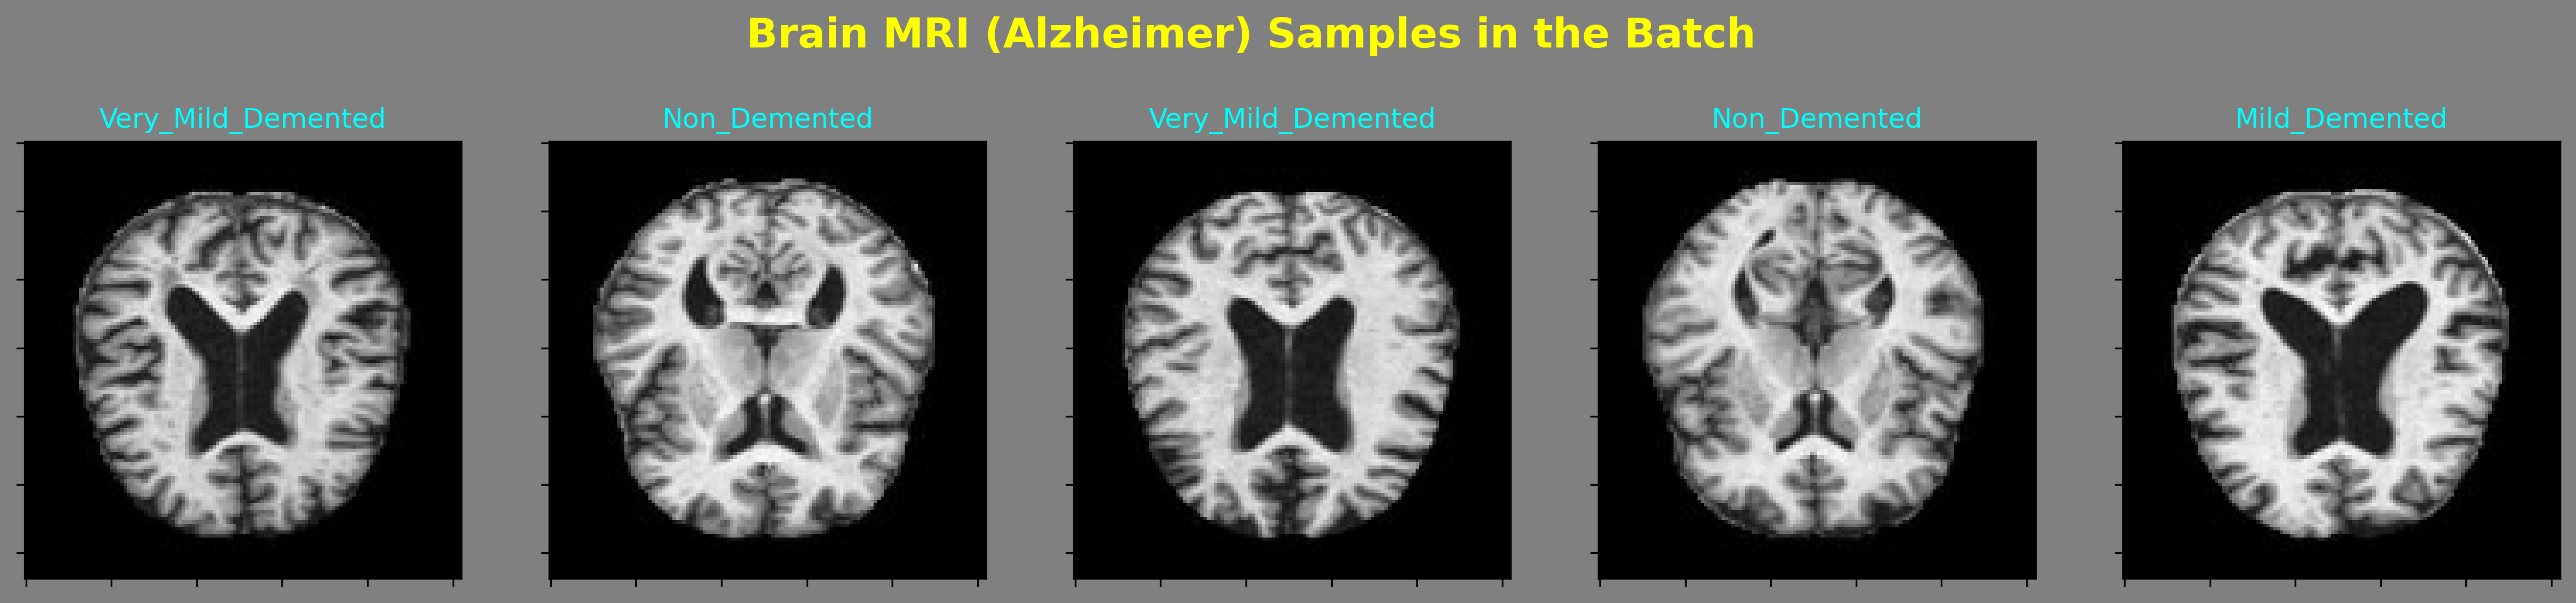

In [16]:
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

In [17]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

In [18]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

# Model Building

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SimpleRNN, TimeDistributed

def build_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add TimeDistributed layer to make the output 3D
    model.add(TimeDistributed(Flatten()))

    # Add Simple RNN layer
    model.add(SimpleRNN(units=64, activation='relu'))

    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model.summary()

    return model

model = build_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Callbacks</h2>

In [21]:
def checkpoint_callback():

    checkpoint_filepath = '/tmp/checkpoint'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 25
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [22]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 1.4168 - accuracy: 0.2456
Epoch 1: val_accuracy improved from -inf to 0.00781, saving model to /tmp/checkpoint
163/163 [==============================] - 148s 869ms/step - loss: 1.4168 - accuracy: 0.2456 - val_loss: 1.5494 - val_accuracy: 0.0078
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 1.3632 - accuracy: 0.2099
Epoch 2: val_accuracy improved from 0.00781 to 0.49219, saving model to /tmp/checkpoint
163/163 [==============================] - 116s 712ms/step - loss: 1.3632 - accuracy: 0.2099 - val_loss: 1.2550 - val_accuracy: 0.4922
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 1.2568 - accuracy: 0.2732
Epoch 3: val_accuracy did not improve from 0.49219
163/163 [==============================] - 113s 692ms/step - loss: 1.2568 - accuracy: 0.2732 - val_loss: 1.2014 - val_accuracy: 0.3578
Epoch 4/25
163/163 [==============================] - ETA: 0s - loss: 0.8854 - accu

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Loss and Accuracy</h2>

In [23]:
# Save the trained model
model.save("your_model_name.h5")


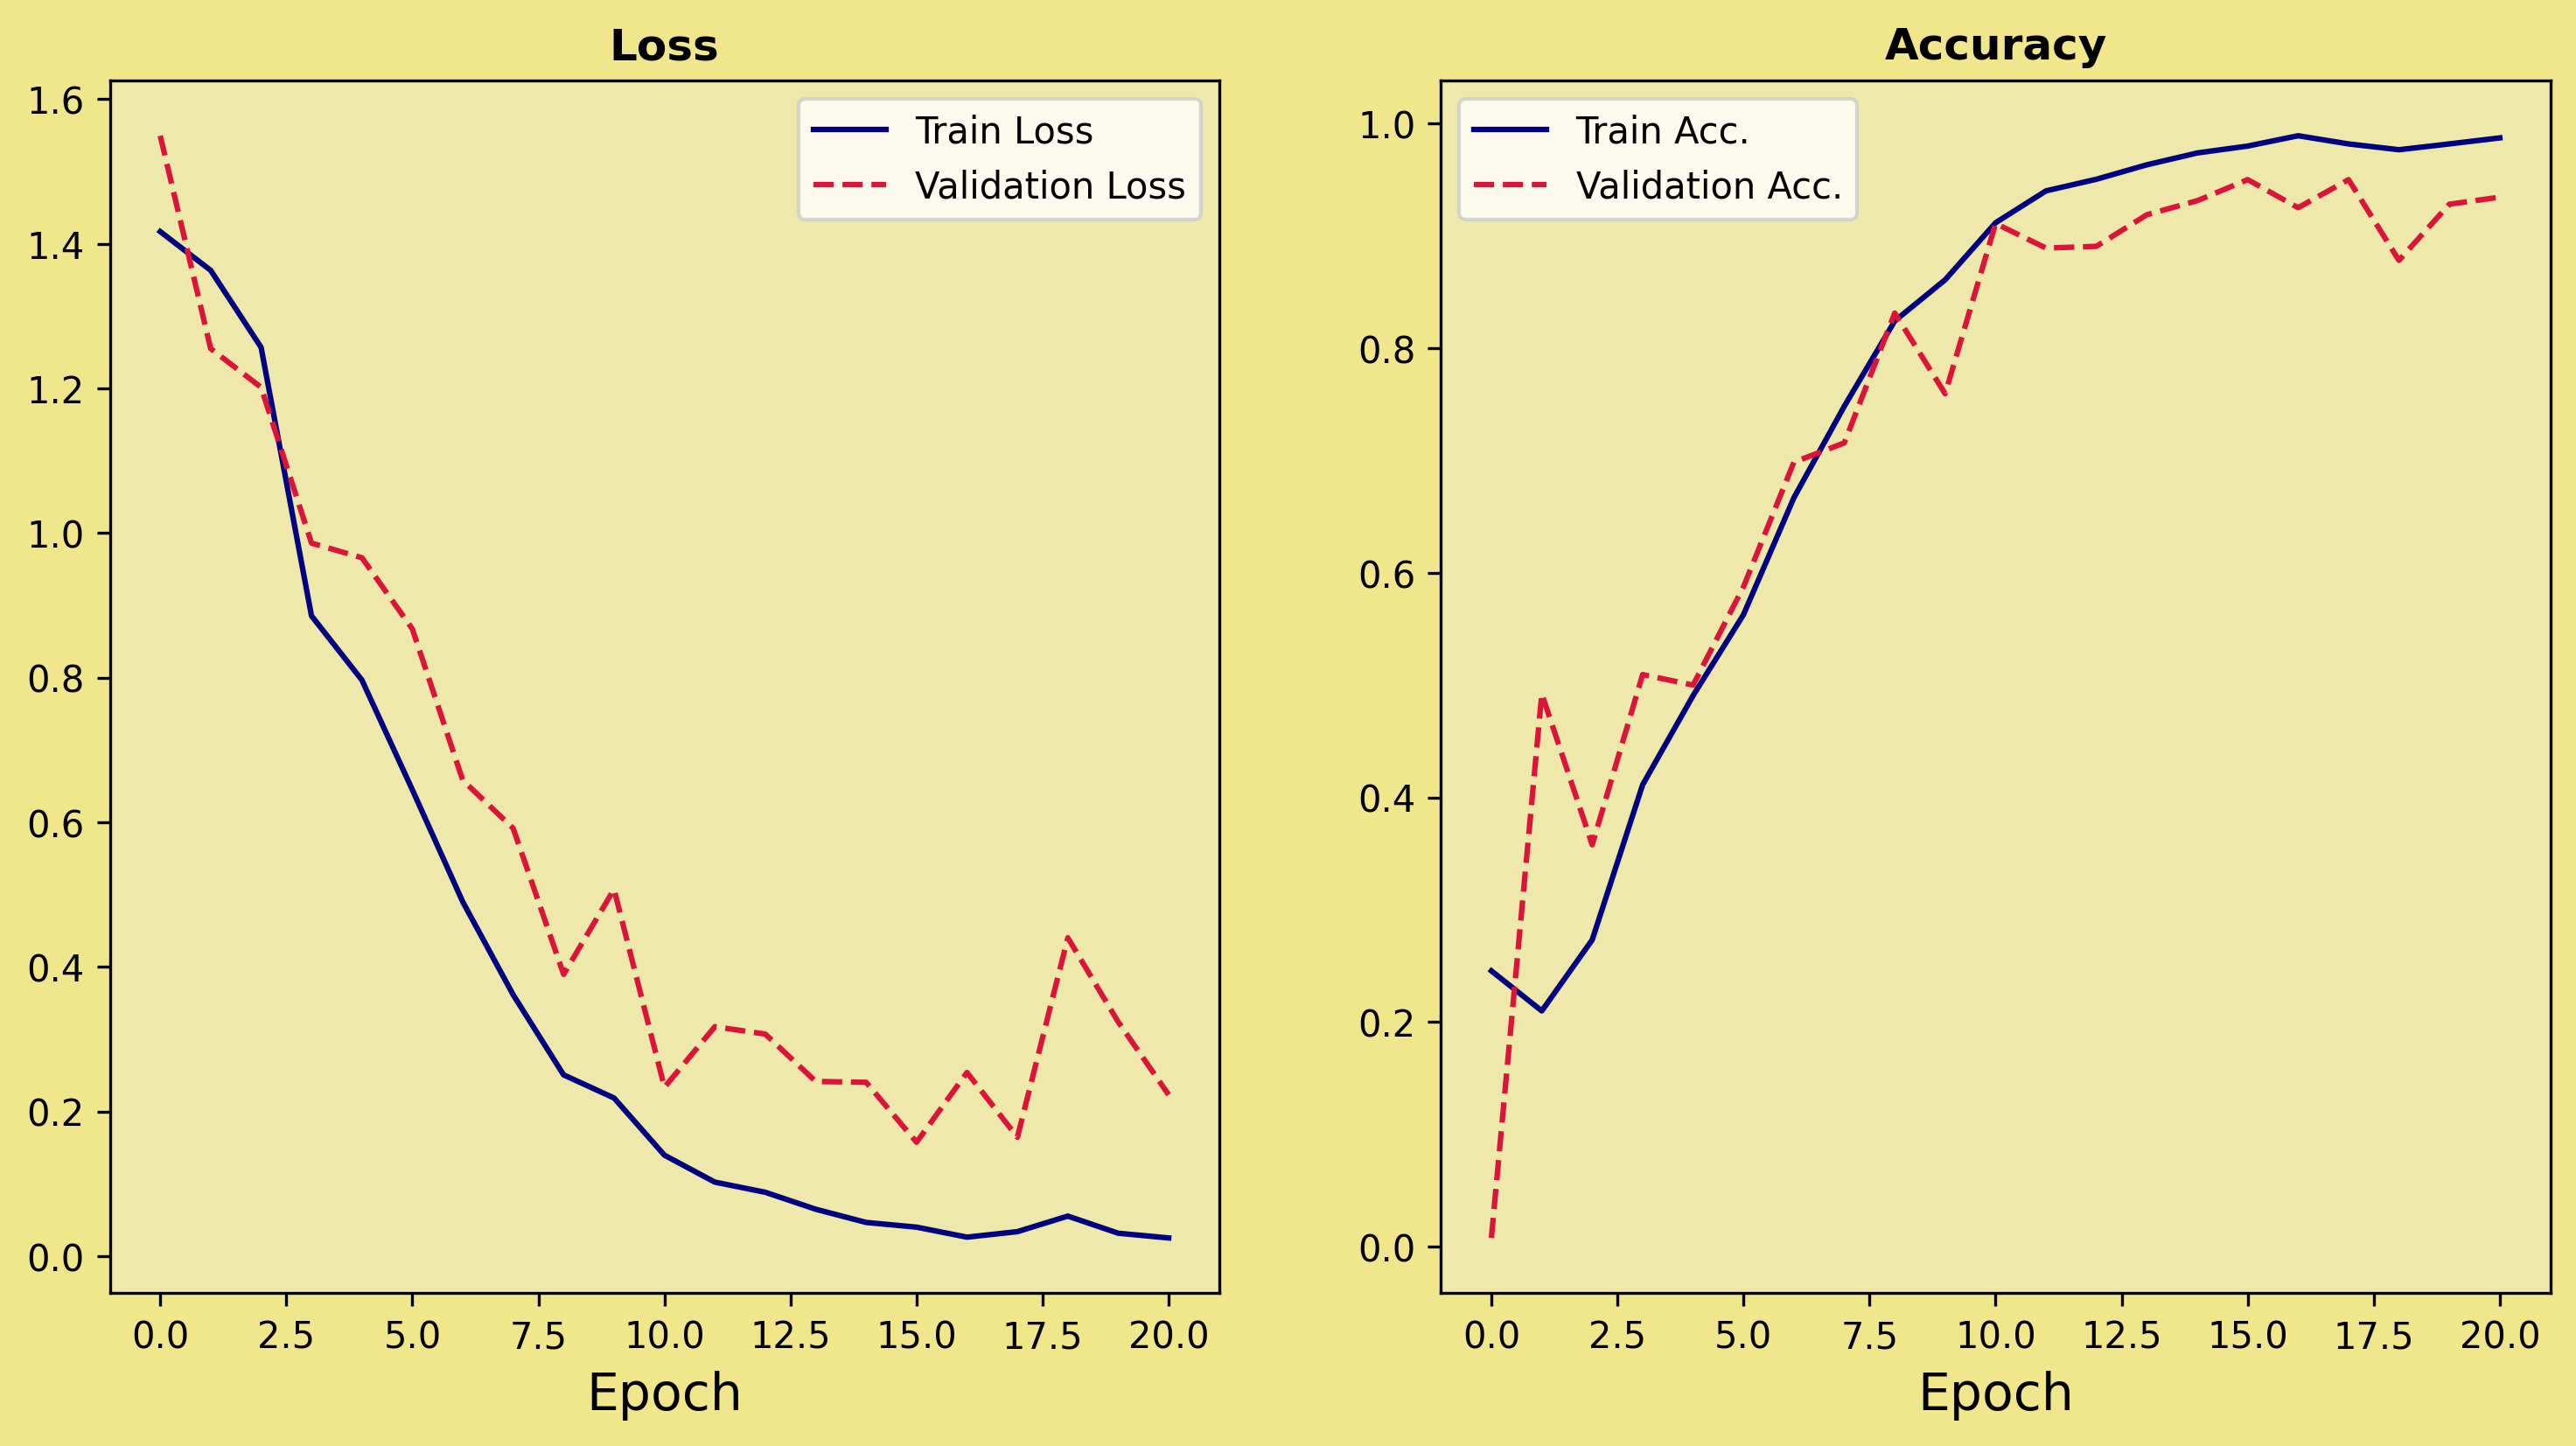

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Evaluating Test Data</h2>

In [25]:
model.evaluate(test_data)

20/20 [==============================] - 27s 1s/step - loss: 0.3262 - accuracy: 0.9203


[0.32619595527648926, 0.9203125238418579]

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Classification Report</h2>

In [26]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       0.97      0.89      0.93        76
 Moderate_Demented       0.90      1.00      0.95         9
      Non_Demented       0.89      0.98      0.93       317
Very_Mild_Demented       0.95      0.83      0.89       238

          accuracy                           0.92       640
         macro avg       0.93      0.93      0.92       640
      weighted avg       0.92      0.92      0.91       640



<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Confusion Matrix</h2>

Text(286.1666666666666, 0.5, 'True')

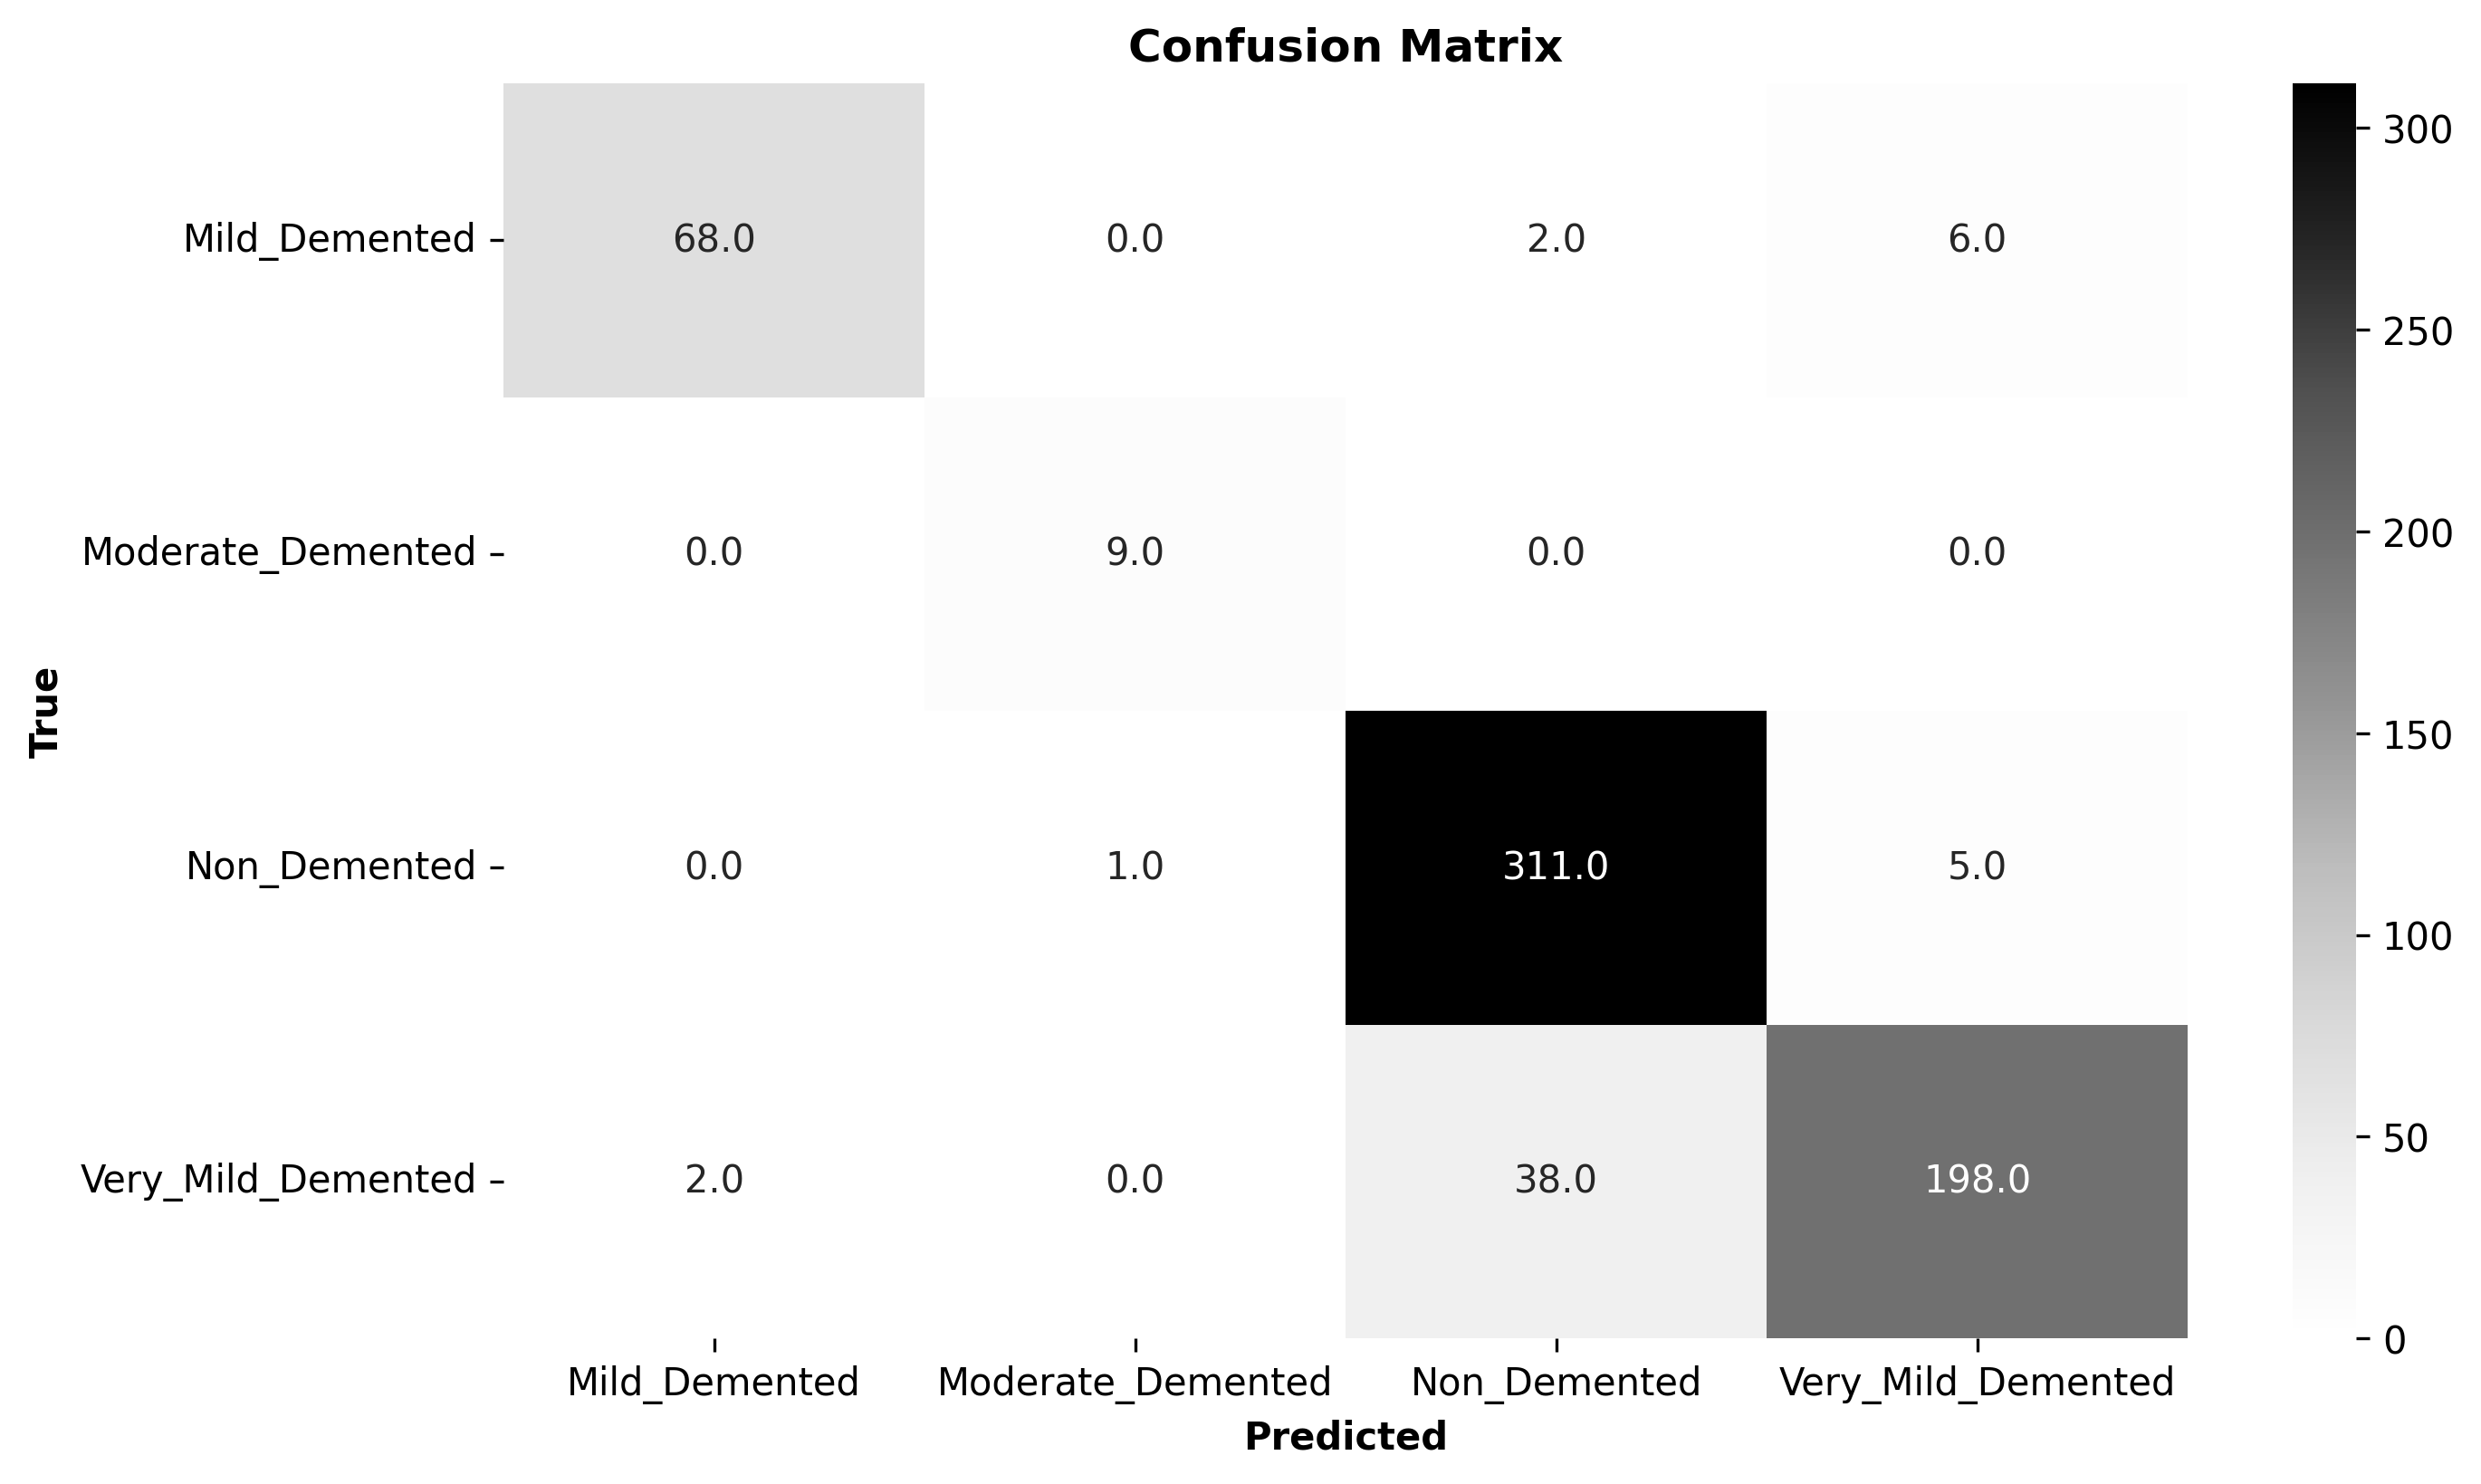

In [27]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Alzheimer Probability of a Random MRI from Test Data</h2>

1/1 [==============================] - 0s 238ms/step


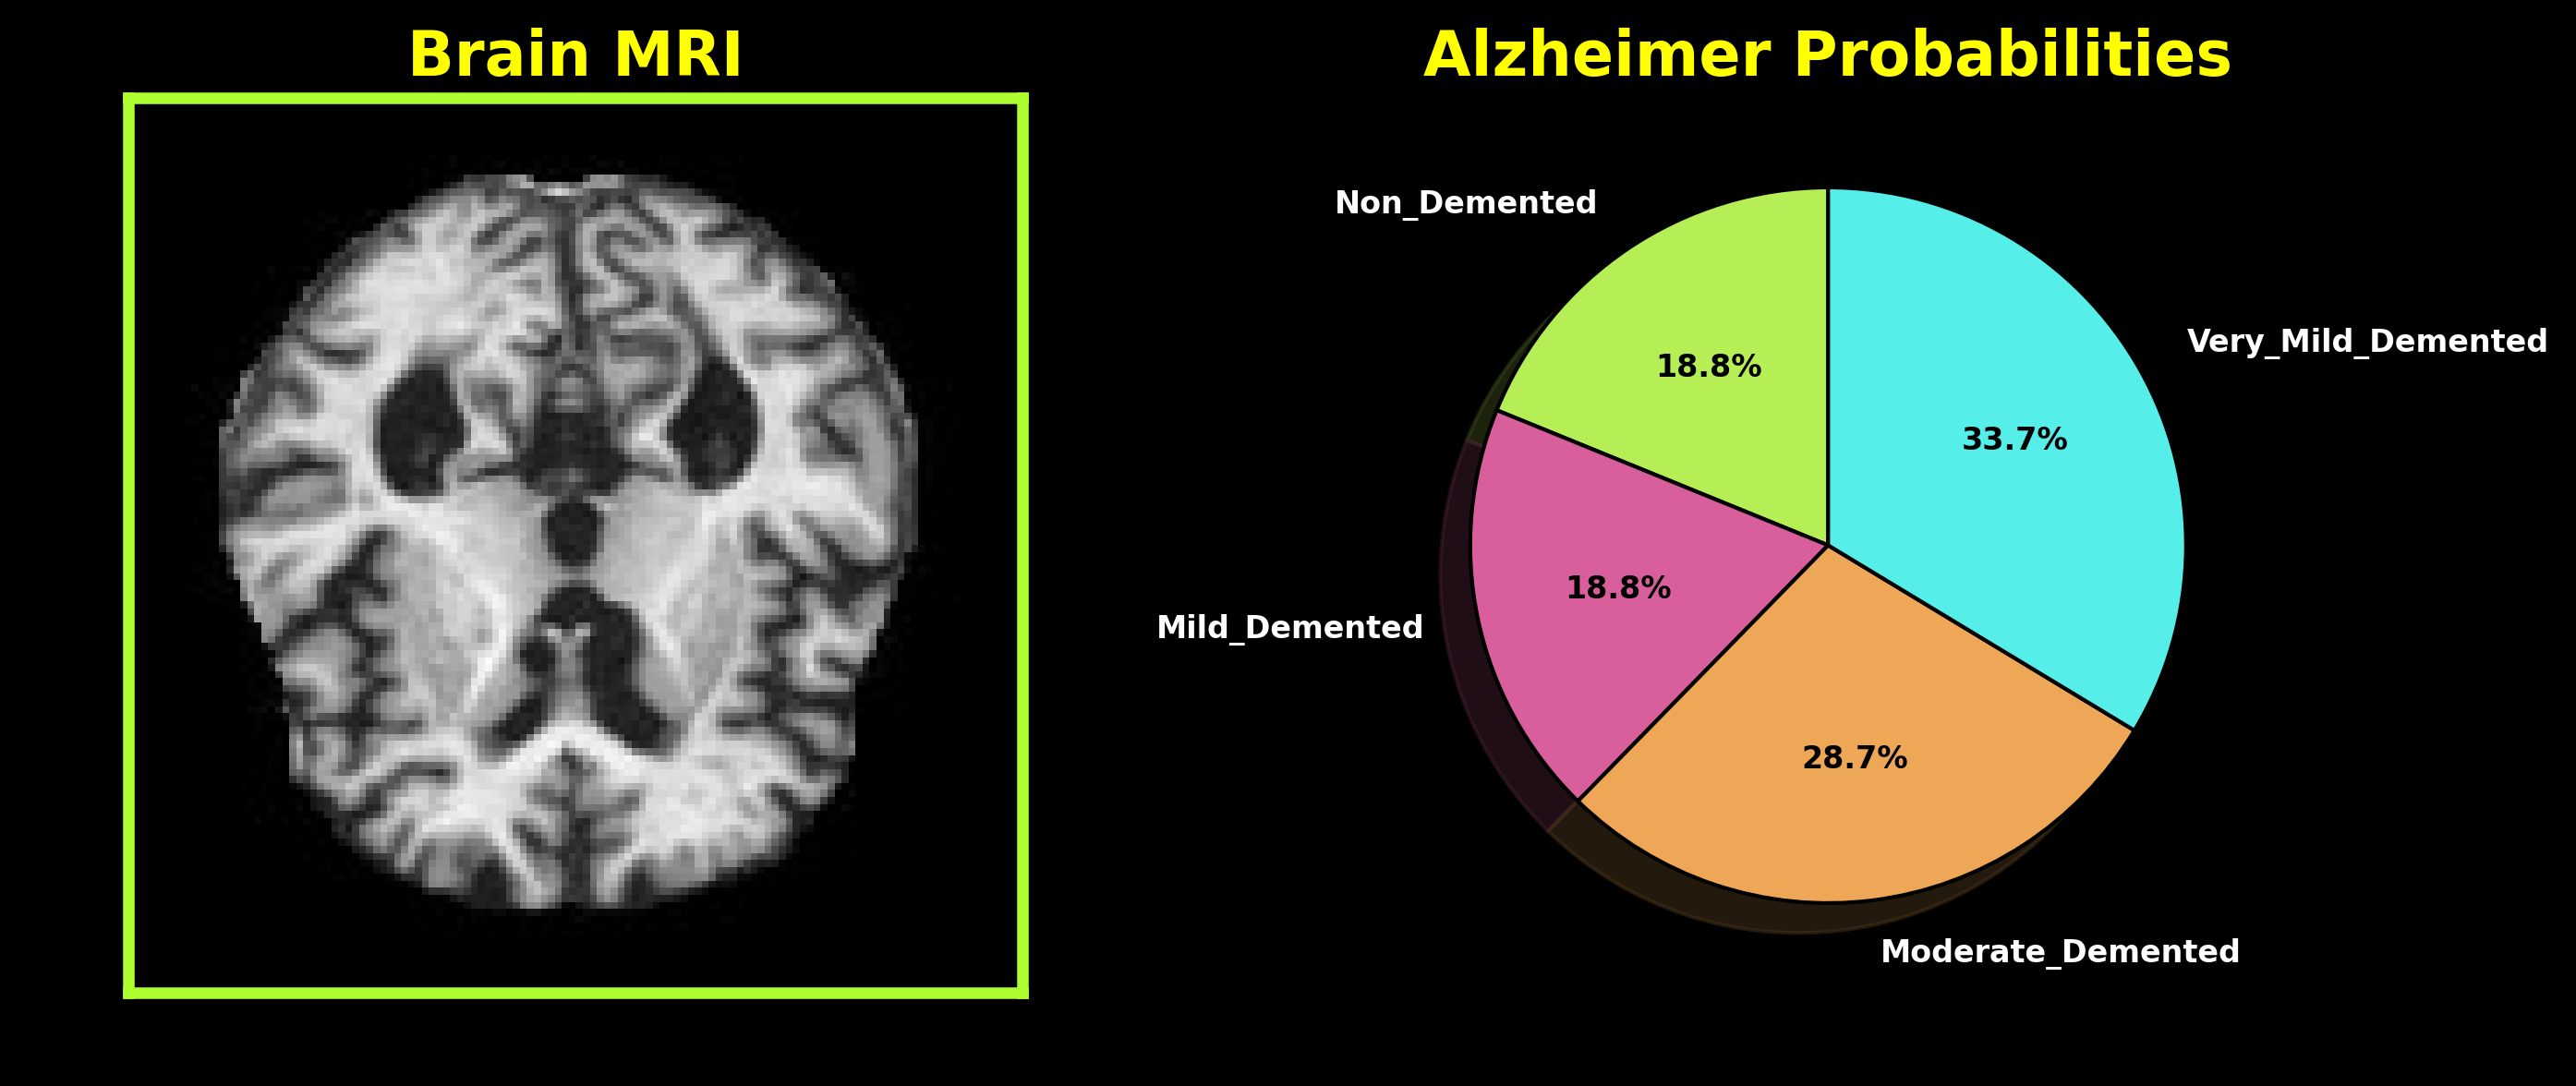

In [28]:
def random_mri_prob_bringer(image_number=0):

    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = model.predict(tf.expand_dims(image, 0))[0]

    probs = list(tf.nn.softmax(pred).numpy())
    probs_dict = dict(zip(class_dist.keys(), probs))

    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4)
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)

    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('Alzheimer Probabilities', color="yellow", fontweight="bold", fontsize=16)

rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Comparing Predicted Classes with the Actual Classes from the Test Data</h2>

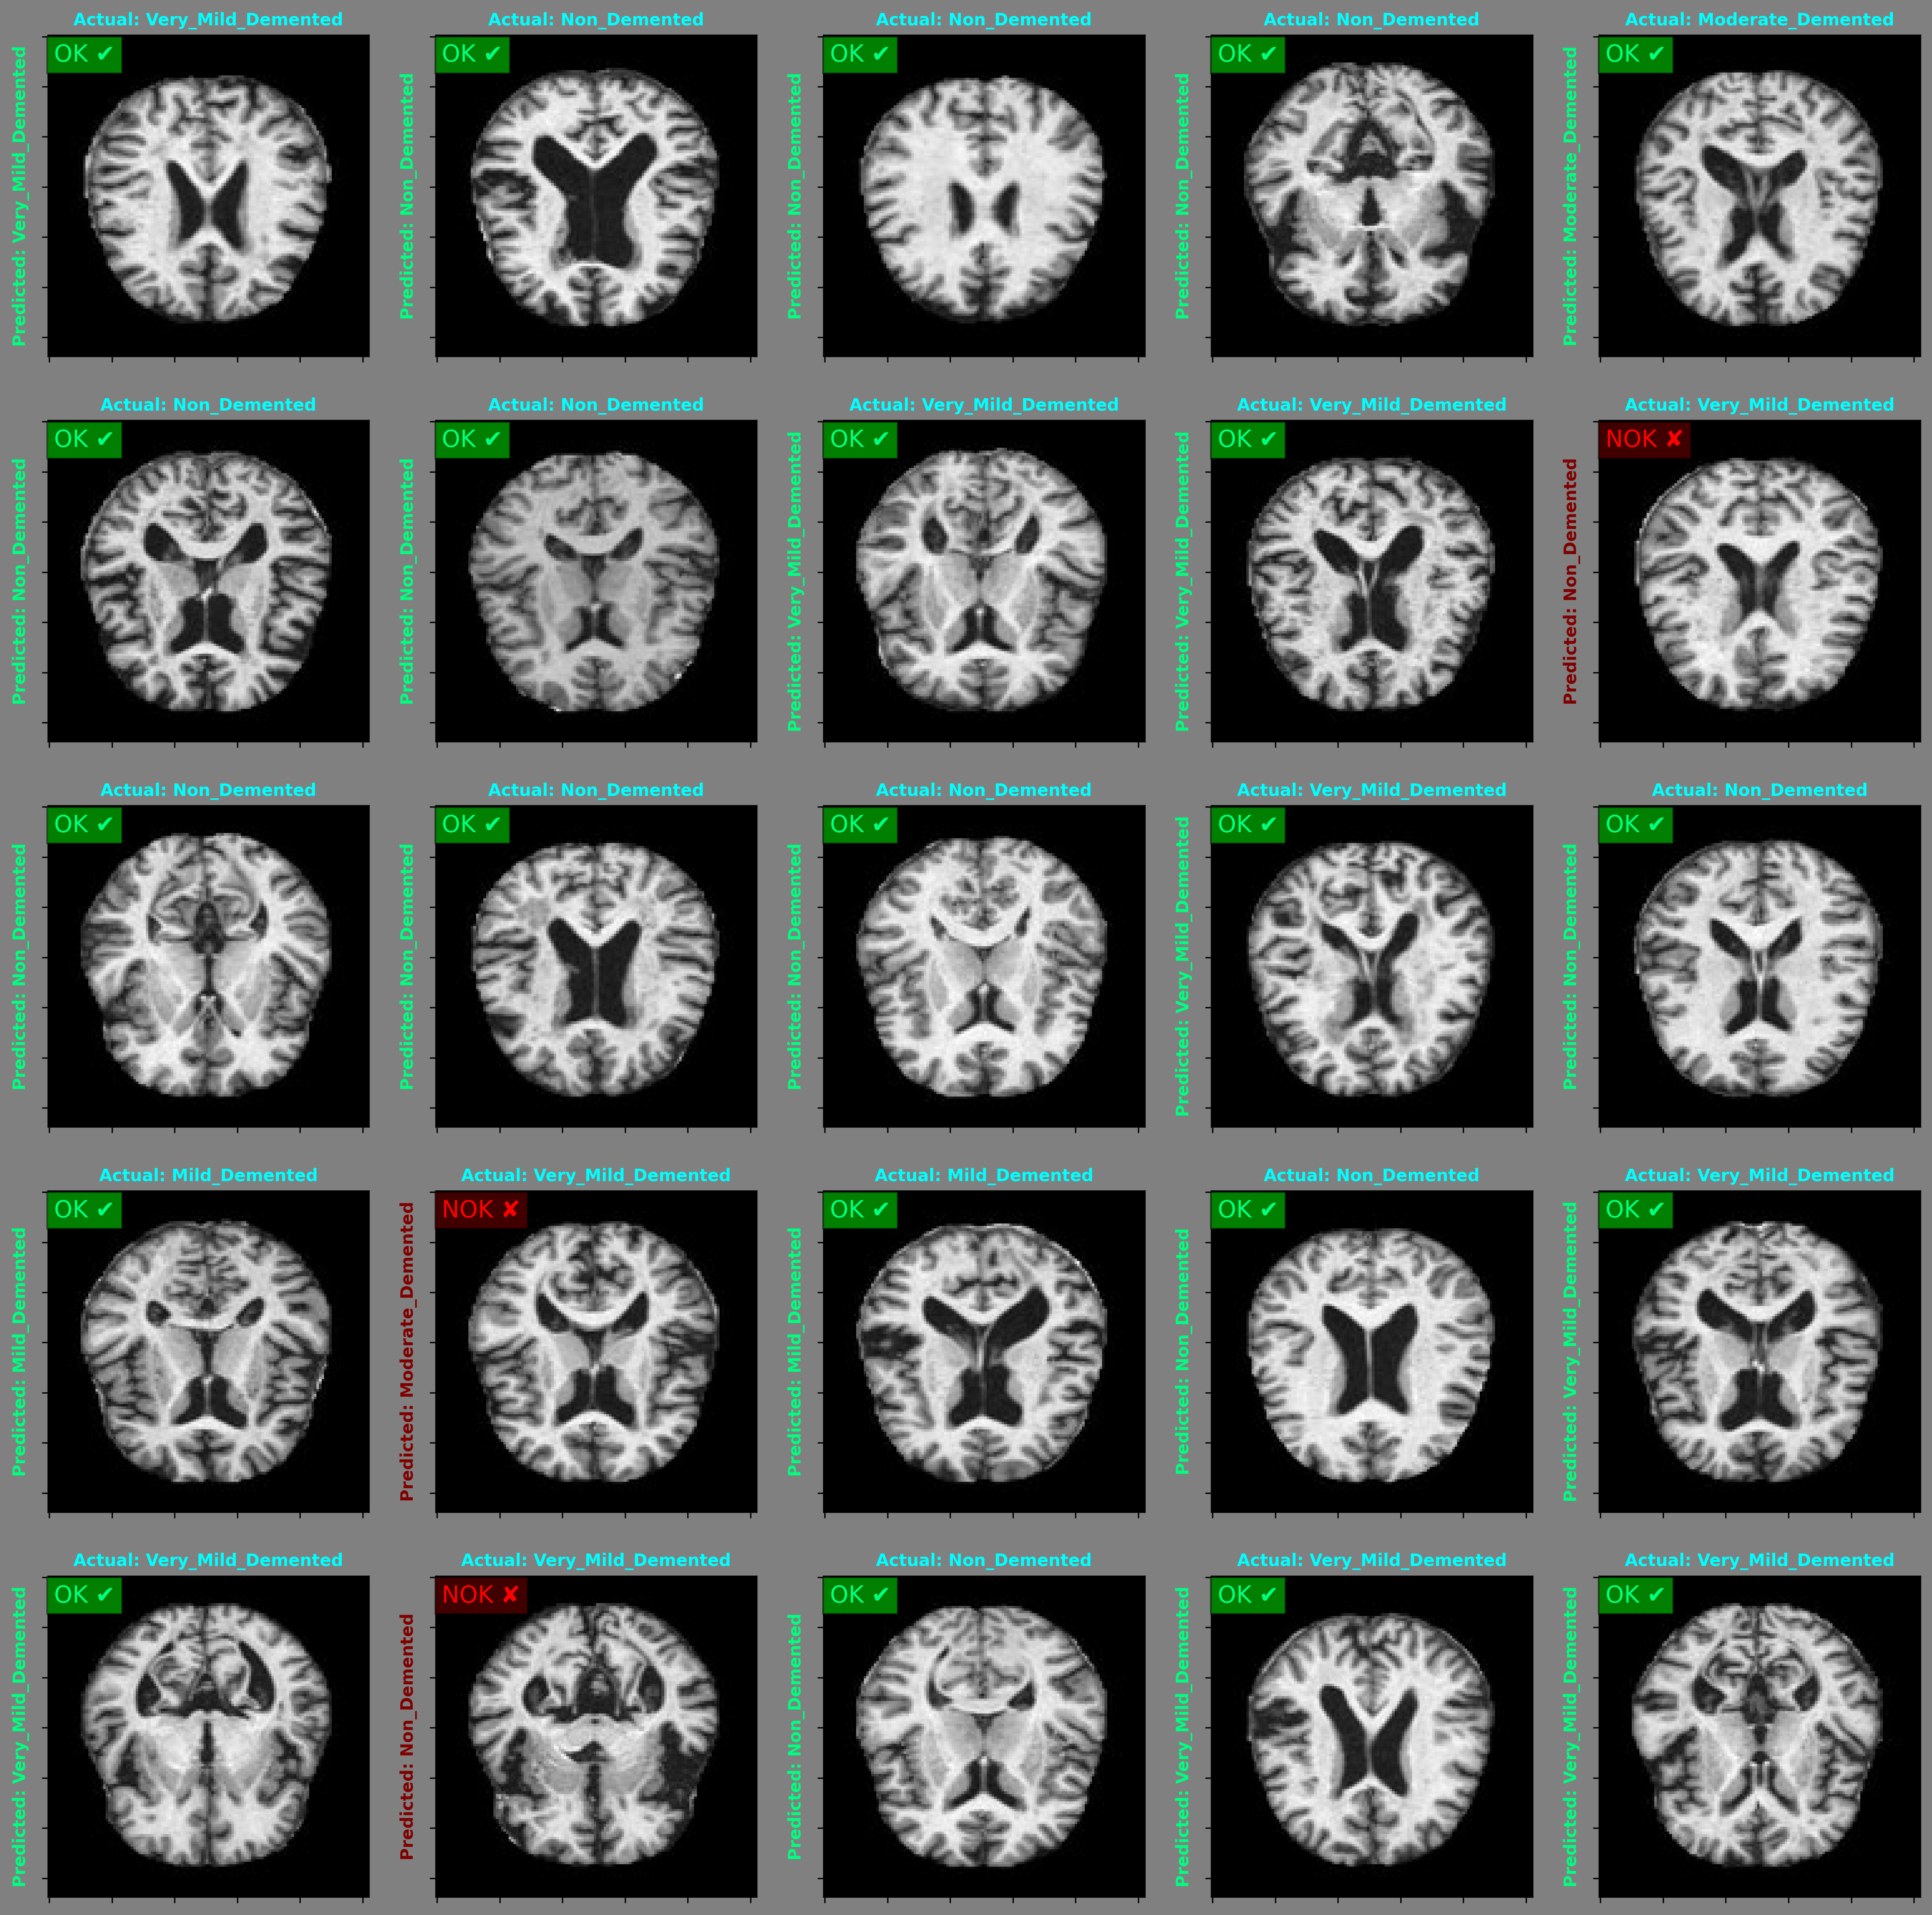

In [29]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])